In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import time
import missingno as msno
import matplotlib.dates as mdates

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Accidents/Data
!ls "/content/drive/My Drive/Colab Notebooks/Data/"
Data_Folder_Name="/content/drive/My Drive/Accidents/Data/"

Mounted at /content/drive
acc_cat.pkl
acc_enc.pkl
acc_rf.pkl
dft-road-casualty-statistics-accident-1979-2021.csv
dft-road-casualty-statistics-casualty-1979-2021.csv
dft-road-casualty-statistics-vehicle-1979-2021.csv
rf_best_071603.pkl
Road-Safety-Open-Dataset-Data-Guide.xlsx
dft-road-casualty-statistics-accident-2020.csv
dft-road-casualty-statistics-casualty-2020.csv
dft-road-casualty-statistics-vehicle-2020.csv
Road-Safety-Open-Dataset-Data-Guide.xlsx


In [3]:
ACC_PATH_ALL =Data_Folder_Name+'dft-road-casualty-statistics-accident-1979-2021.csv'
print(ACC_PATH_ALL)
acc_df = (pd.read_csv(ACC_PATH_ALL, parse_dates=["date"])[lambda x: x['accident_year'] > 2018])


/content/drive/My Drive/Accidents/Data/dft-road-casualty-statistics-accident-1979-2021.csv


<ipython-input-3-5b77c6eda276>:3: DtypeWarning: Columns (0,2,15,16,35) have mixed types. Specify dtype option on import or set low_memory=False.
  acc_df = (pd.read_csv(ACC_PATH_ALL, parse_dates=["date"])[lambda x: x['accident_year'] > 2018])
<ipython-input-3-5b77c6eda276>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  acc_df = (pd.read_csv(ACC_PATH_ALL, parse_dates=["date"])[lambda x: x['accident_year'] > 2018])


In [ ]:
acc_df.replace(-1, np.nan, inplace=True)
acc_df.drop(columns=['location_easting_osgr', 'location_northing_osgr','second_road_class', 'second_road_number', 'junction_control','local_authority_district'],inplace=True)
acc_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 309822 entries, 8394089 to 8703910
Data columns (total 30 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   accident_index                               309822 non-null  object        
 1   accident_year                                309822 non-null  int64         
 2   accident_reference                           309822 non-null  object        
 3   longitude                                    309763 non-null  float64       
 4   latitude                                     309763 non-null  float64       
 5   police_force                                 309822 non-null  int64         
 6   accident_severity                            309822 non-null  int64         
 7   number_of_vehicles                           309822 non-null  int64         
 8   number_of_casualties                         309822 non-n

In [ ]:
acc_df.isna().sum().sort_values(ascending=False)

special_conditions_at_site                     809
carriageway_hazards                            780
pedestrian_crossing_human_control              551
pedestrian_crossing_physical_facilities        515
speed_limit                                     92
longitude                                       59
latitude                                        59
weather_conditions                              13
light_conditions                                13
junction_detail                                  5
did_police_officer_attend_scene_of_accident      1
accident_index                                   0
road_type                                        0
trunk_road_flag                                  0
urban_or_rural_area                              0
road_surface_conditions                          0
first_road_number                                0
accident_year                                    0
first_road_class                                 0
local_authority_highway        

In [ ]:
#dealing with missing values as in datawrangling

acc_df['trunk_road_flag'].fillna(3,inplace=True) # a new value this is for outside england
acc_df['road_surface_conditions'].fillna(9,inplace=True) # 9 is selfreport
acc_df.dropna(axis=0,inplace=True) ## remove few instances for which we miss some values
acc_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 308586 entries, 8394089 to 8703910
Data columns (total 30 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   accident_index                               308586 non-null  object        
 1   accident_year                                308586 non-null  int64         
 2   accident_reference                           308586 non-null  object        
 3   longitude                                    308586 non-null  float64       
 4   latitude                                     308586 non-null  float64       
 5   police_force                                 308586 non-null  int64         
 6   accident_severity                            308586 non-null  int64         
 7   number_of_vehicles                           308586 non-null  int64         
 8   number_of_casualties                         308586 non-n

In [ ]:
#float to int
intcols=['speed_limit','junction_detail','pedestrian_crossing_human_control','pedestrian_crossing_physical_facilities', 'light_conditions','weather_conditions',
         'road_surface_conditions','special_conditions_at_site', 'carriageway_hazards','did_police_officer_attend_scene_of_accident','trunk_road_flag']
acc_df[intcols]=acc_df[intcols].astype('int')

acc_df["date"] = pd.to_datetime(acc_df["date"], format="%d/%m/%Y")
acc_df["hour"] = acc_df.time.str[0:2]
acc_df['hour'] = acc_df['hour'].astype('int')  # it has some old nan

#new_weekend column
acc_df['weekend'] = np.where(acc_df['day_of_week'].isin([1,7]), 1, 0)   # 1 is Sunday , 7 is Saturday
#new month column
acc_df['month'] = acc_df ['date'].apply(lambda time: time.month)
## could change this to lambda
acc_df['covid']=((acc_df['date']> '2020-02-28')&(acc_df['date']< '2021-03-29')).astype(int)

acc_df['accident_level'] = np.where(acc_df['accident_severity']==3, 0, 1)  # Binary target value
d64 = dict.fromkeys(acc_df.select_dtypes(np.int64).columns, np.int32)
acc_df = acc_df.astype(d64)

acc_df.loc[acc_df['did_police_officer_attend_scene_of_accident'] >=2 , 'did_police_officer_attend_scene_of_accident'] = 0     #yes 1 no 0
acc_df.loc[acc_df['urban_or_rural_area'] >=2 , 'did_police_officer_attend_scene_of_accident'] = 0     #Urban 1 Rural 0

acc_df.loc[acc_df['number_of_vehicles'] > 4, 'number_of_vehicles'] = 5
acc_df.loc[acc_df['number_of_casualties'] > 4, 'number_of_casualties'] = 5


acc_df.info()





<class 'pandas.core.frame.DataFrame'>
Int64Index: 308586 entries, 8394089 to 8703910
Data columns (total 35 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   accident_index                               308586 non-null  object        
 1   accident_year                                308586 non-null  int32         
 2   accident_reference                           308586 non-null  object        
 3   longitude                                    308586 non-null  float64       
 4   latitude                                     308586 non-null  float64       
 5   police_force                                 308586 non-null  int32         
 6   accident_severity                            308586 non-null  int32         
 7   number_of_vehicles                           308586 non-null  int32         
 8   number_of_casualties                         308586 non-n

In [ ]:
acc_df.columns
acc_df.loc[acc_df['did_police_officer_attend_scene_of_accident'] >=2 , 'did_police_officer_attend_scene_of_accident'] = 0     #yes 1 no 0
acc_df.loc[acc_df['urban_or_rural_area'] >=2 , 'did_police_officer_attend_scene_of_accident'] = 0     #Urban 1 Rural 0

acc_df.did_police_officer_attend_scene_of_accident.unique()

array([0, 1], dtype=int32)

In [ ]:
# Target Imbalance:
print('imbalance ratio: ',round(acc_df.accident_level.value_counts()[0]/acc_df.accident_level.value_counts()[1],2),"to 1  ,  with ",
                          round(100*acc_df.accident_level.value_counts()[1]/len(acc_df),2),"% being Major accidents and the rest Minor")
acc_df.accident_level.value_counts()

imbalance ratio:  3.61 to 1  ,  with  21.7 % being Major accidents and the rest Minor


0    241616
1     66970
Name: accident_level, dtype: int64

In [ ]:
acc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308586 entries, 8394089 to 8703910
Data columns (total 35 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   accident_index                               308586 non-null  object        
 1   accident_year                                308586 non-null  int32         
 2   accident_reference                           308586 non-null  object        
 3   longitude                                    308586 non-null  float64       
 4   latitude                                     308586 non-null  float64       
 5   police_force                                 308586 non-null  int32         
 6   accident_severity                            308586 non-null  int32         
 7   number_of_vehicles                           308586 non-null  int32         
 8   number_of_casualties                         308586 non-n

In [ ]:
#acc_df['road_surface_conditions'].fillna(9,inplace=True) # 9 is unknown
acc_df.nunique()

accident_index                                 308586
accident_year                                       3
accident_reference                             308449
longitude                                      291813
latitude                                       283194
police_force                                       52
accident_severity                                   3
number_of_vehicles                                 16
number_of_casualties                               21
date                                             1096
day_of_week                                         7
time                                             1440
local_authority_ons_district                      383
local_authority_highway                           208
first_road_class                                    6
first_road_number                                3505
road_type                                           6
speed_limit                                         6
junction_detail             

In [ ]:
## There are many categorical data in integer format we need to take care of

#numerical Features
numcols=['longitude','latitude','number_of_vehicles','number_of_casualties','speed_limit','accident_year']

# to be dropped for ML
dropcols=['accident_index','accident_reference','accident_severity','date','time','local_authority_ons_district','local_authority_highway','lsoa_of_accident_location','first_road_number']

#Categorical Features
catcols=['police_force','day_of_week','first_road_class','road_type','junction_detail','pedestrian_crossing_human_control','pedestrian_crossing_physical_facilities',
         'light_conditions','weather_conditions','road_surface_conditions','special_conditions_at_site','carriageway_hazards','urban_or_rural_area',
         'did_police_officer_attend_scene_of_accident','trunk_road_flag','hour','weekend','month','covid','accident_level']

#Categorical:     binary columns
binarycol=['covid','weekend','urban_or_rural_area','accident_level','did_police_officer_attend_scene_of_accident']

#Categorical:     Nominal Columns
nominalcol=['police_force','first_road_class','road_type','junction_detail','pedestrian_crossing_human_control','pedestrian_crossing_physical_facilities',
         'light_conditions','weather_conditions','road_surface_conditions','special_conditions_at_site','carriageway_hazards','month','day_of_week','hour','trunk_road_flag']

# Convert binary columns to uint8 in the DataFrame and nominal columns to category
acc_df[binarycol] = acc_df[binarycol].astype('uint8')
acc_df[nominalcol] = acc_df[nominalcol].astype('category')




In [ ]:
print(set(acc_df.columns)-set(binarycol)-set(nominalcol)-set(numcols)-set(dropcols))
print("cols to be dropped as noise in ML:",dropcols)


set()
cols to be dropped as noise in ML: ['accident_index', 'accident_reference', 'accident_severity', 'date', 'time', 'local_authority_ons_district', 'local_authority_highway', 'lsoa_of_accident_location', 'first_road_number']


In [ ]:
df_cat = pd.concat([dfnum,acc_df[catcols]], axis = 1, sort = False)
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308586 entries, 8394089 to 8703910
Data columns (total 26 columns):
 #   Column                                       Non-Null Count   Dtype   
---  ------                                       --------------   -----   
 0   longitude                                    308586 non-null  float64 
 1   latitude                                     308586 non-null  float64 
 2   number_of_vehicles                           308586 non-null  int32   
 3   number_of_casualties                         308586 non-null  int32   
 4   speed_limit                                  308586 non-null  int32   
 5   accident_year                                308586 non-null  int32   
 6   police_force                                 308586 non-null  category
 7   day_of_week                                  308586 non-null  category
 8   first_road_class                             308586 non-null  category
 9   road_type                                


**df_cat above is categorical data set:**

When using RandomForestClassifier or some other clf models, you can pass the categorical variables directly to the classifier without one-hot encoding. It is important to ensure that the categorical variables are properly encoded as integers or categorical data types in the input data.

**We also make a onehot encoded (dummy version actually)  as df_encoded:**


In [ ]:
# Perform one-hot encoding on the nominal columns
df_encoded = pd.get_dummies(df_cat[nominalcol])

# Concatenate the encoded columns with the remaining columns
df_encoded = pd.concat([df_cat.drop(nominalcol, axis=1), df_encoded], axis=1)
df_encoded.head(2)

,longitude,latitude,number_of_vehicles,number_of_casualties,speed_limit,accident_year,urban_or_rural_area,did_police_officer_attend_scene_of_accident,weekend,covid,...,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,trunk_road_flag_1,trunk_road_flag_2,trunk_road_flag_3
8394089,-0.153842,51.508057,2,3,30,2019,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
8394090,-0.127949,51.436208,2,1,30,2019,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [52]:
# Create an instance of OneHotEncoder
one_hot_encoder = OneHotEncoder()
# This usualy to be done after  split
# Apply one-hot encoding to the nominal features in X_train
#X_train_encoded = one_hot_encoder.fit_transform(X_train[['nominal_feature']])

# Apply one-hot encoding to the nominal features in X_test
#X_test_encoded = one_hot_encoder.transform(X_test[['nominal_feature']])

# Convert the encoded features to a DataFrame
#X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=one_hot_encoder.get_feature_names(['nominal_feature']))
#X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=one_hot_encoder.get_feature_names(['nominal_feature']))

# Concatenate the encoded features with the original DataFrame
#X_train_encoded = pd.concat([X_train, X_train_encoded_df], axis=1)
#X_test_encoded = pd.concat([X_test, X_test_encoded_df], axis=1)

# Drop the original nominal feature from the encoded DataFrame
#X_train_encoded = X_train_encoded.drop(['nominal_feature'], axis=1)
#X_test_encoded = X_test_encoded.drop(['nominal_feature'], axis=1)

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308586 entries, 8394089 to 8703910
Columns: 178 entries, longitude to trunk_road_flag_3
dtypes: float64(2), int32(4), uint8(172)
memory usage: 62.4 MB


In [ ]:
#saving the datasets
df_cat.to_pickle("./drive/MyDrive/Accidents/Data/acc_cat.pkl")
df_encoded.to_pickle("./drive/MyDrive/Accidents/Data/acc_enc.pkl")


**Machine Learning data load **   **START HERE**

In [7]:
import time
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import make_scorer, average_precision_score


!pip install scikit-plot
import scikitplot as skplt



In [8]:
#loading the datasets
df_cat = pd.read_pickle("./drive/MyDrive/Accidents/Data/acc_cat.pkl")
df_ohe = pd.read_pickle("./drive/MyDrive/Accidents/Data/acc_enc.pkl")
!ls drive/MyDrive/Accidents/Data

acc_cat.pkl
acc_enc.pkl
acc_rf.pkl
dft-road-casualty-statistics-accident-1979-2021.csv
dft-road-casualty-statistics-casualty-1979-2021.csv
dft-road-casualty-statistics-vehicle-1979-2021.csv
rf_best_071603.pkl
Road-Safety-Open-Dataset-Data-Guide.xlsx


In [9]:
#checking the dataframes
#print(df_cat.nunique())
print(df_ohe.shape)
df_cat.info()

(308586, 178)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 308586 entries, 8394089 to 8703910
Data columns (total 26 columns):
 #   Column                                       Non-Null Count   Dtype   
---  ------                                       --------------   -----   
 0   longitude                                    308586 non-null  float64 
 1   latitude                                     308586 non-null  float64 
 2   number_of_vehicles                           308586 non-null  int32   
 3   number_of_casualties                         308586 non-null  int32   
 4   speed_limit                                  308586 non-null  int32   
 5   accident_year                                308586 non-null  int32   
 6   police_force                                 308586 non-null  category
 7   day_of_week                                  308586 non-null  category
 8   first_road_class                             308586 non-null  category
 9   road_type                  

## Making Train, Validation, and Test Sets

In [12]:

Xc = df_cat.drop(['accident_level'], axis=1)
yc = df_cat['accident_level']

# Split the data into train and test sets
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.17, stratify=yc, random_state=82)

# Further split the train set into train and validation sets
Xc_train, Xc_val, yc_train, yc_val = train_test_split(Xc_train, yc_train, test_size=0.2, stratify=yc_train, random_state=82)


print( f"Shapes of the datasets with multi label categories: \n")
print("Train set shape:", Xc_train.shape, yc_train.shape)
print("Validation set shape:", Xc_val.shape, yc_val.shape)
print("Test set shape:", Xc_test.shape, yc_test.shape)





Xe = df_ohe.drop(['accident_level'], axis=1)
ye = df_ohe['accident_level']

# Split the data into train and test sets
Xe_train, Xe_test, ye_train, ye_test = train_test_split(Xe, ye, test_size=0.17, stratify=ye, random_state=82)

# Further split the train set into train and validation sets
Xe_train, Xe_val, ye_train, ye_val = train_test_split(Xe_train, ye_train, test_size=0.2, stratify=ye_train, random_state=82)


print( f"\n\n Shapes of the Encoded datasets: \n")
print("Train set shape:", Xe_train.shape, ye_train.shape)
print("Validation set shape:", Xe_val.shape, ye_val.shape)
print("Test set shape:", Xe_test.shape, ye_test.shape)

Shapes of the datasets with multi label categories: 

Train set shape: (204900, 25) (204900,)
Validation set shape: (51226, 25) (51226,)
Test set shape: (52460, 25) (52460,)


 Shapes of the Encoded datasets: 

Train set shape: (204900, 177) (204900,)
Validation set shape: (51226, 177) (51226,)
Test set shape: (52460, 177) (52460,)


## Dataset Imbalance Strategies:

**Here I check three ways to handle imbalance:**

**1- undersampling**

**2-oversampling Using SMOTE**

**3-using balance weights in rf_clf : (feading Xc or Xe directly)**

### UnderSampling

In [14]:
# UnderSampling
from imblearn.under_sampling import RandomUnderSampler

# Create the RandomUnderSampler object
undersampler = RandomUnderSampler(random_state=82)

# Apply undersampling on X_train and y_train for both cat and ohe dataframes
Xc_train_us, yc_train_us = undersampler.fit_resample(Xc_train, yc_train)  # categorical only train set

Xe_train_us, ye_train_us = undersampler.fit_resample(Xe_train, ye_train)  # encoded only train set

#after finetuning the best model we can do it for whole dataset for unseen data

# class distribution before
print("Initial Class distribution :")
print(yc_train.value_counts())
print(ye_train.value_counts())
# Verify the class distribution after undersampling
print("Class distribution after undersampling:")
print(yc_train_us.value_counts())
print(ye_train_us.value_counts())


Initial Class distribution :
0    160432
1     44468
Name: accident_level, dtype: int64
0    160432
1     44468
Name: accident_level, dtype: int64
Class distribution after undersampling:
0    44468
1    44468
Name: accident_level, dtype: int64
0    44468
1    44468
Name: accident_level, dtype: int64


### Oversampling with SMOTE:

In [30]:
#from imblearn.over_sampling import SMOTE

# Create the SMOTE object
smote = SMOTE(random_state=82)

# Apply SMOTE on X_train and y_train
Xc_train_os, yc_train_os = smote.fit_resample(Xc_train, yc_train)   ## This produces a lot of nan values
print("Number of nan generated values for Xc: ",Xc_train_os.isna().sum().sum())
#so for smote we only use encoded values here

Xe_train_os, ye_train_os = smote.fit_resample(Xe_train, ye_train)
print("Number of nan generated values foe Xe: ",Xe_train_os.isna().sum().sum())


# Verify the class distribution after oversampling
print("Class distribution after oversampling:")
print(ye_train_os.value_counts())

Number of nan generated values for Xc:  478813
Number of nan generated values foe Xe:  0
Class distribution after oversampling:
0    160432
1    160432
Name: accident_level, dtype: int64


**Now we can work on to use a more thourough dataset by implementing additional data regarding vehicles , but lets first do some initial testing on the performance of a Random Forrest Classifier on these processed data first:**

In [63]:
# Here is a function to perform a quick evaluation of each model:
def evaluate_classifier(model, X_test, y_test,index = ['Actual Major', 'Actual Minor' ]):

    """
    Takes a model and its test data.
    Prints and returns model metrics.
    """

    # get predictions
    y_pred = model.predict(X_test)

    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)[:,1]

    # compute Area under the curve
    roc_auc = roc_auc_score(y_test, y_pred)

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # plot ROC curve
    title = 'ROC Curve:  AUC =' + str(roc_auc.round(3))
    _ = plt.figure(figsize=(5,5))
    _ = plt.plot(fpr, tpr)
    _ = plt.plot([0,1], [0,1], 'k--')
    _ = plt.xlabel('False Positive Rate (FPR)')
    _ = plt.ylabel('True Positive Rate (TPR)')
    _ = plt.title(title)
    _ = plt.legend(['predictive power','random vector'])
    # show plot when function is called, plot not returned
    plt.show()


    # construct confusion matrix
    #conf_matrx = pd.DataFrame(confusion_matrix(y_test, y_pred))
    #conf_matrx.columns = ['Predict: NO', 'Predict: YES']
    #conf_matrx.index = ['Actual: NO', 'Actual: YES']

    conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index = index,
                           columns = [f'predicted /n Major', f'predicted /n Minor'])

    conf_matrix

    # get classification report
    report = classification_report(y_test, y_pred)
    print(report)
    return conf_matrix, report


# Here is a function to perform a quick evaluation of each model:
def ROC_PRC(model, X_test, y_test,index = ['Actual Major', 'Actual Minor' ]):

    y_pred_prob = rf_best.predict_proba(X_test)

    #plot roc curve and  print AUC score
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    skplt.metrics.plot_roc(y_test, y_pred_prob, ax=axes[0])
    axes[0].set_title('ROC Curve - Categorical Version')
    skplt.metrics.plot_precision_recall(y_test, y_pred_prob, ax=axes[1])
    axes[1].set_title('Precision-Recall Curve  - Categorical Version')
    plt.tight_layout()
    plt.show()
    auc_score = roc_auc_score(y_test, y_pred)
    auprc_score = average_precision_score(y_test, y_pred_prob[:, 1])
    print('AUC score:  {}         AUPRC score:  {}'.format(auc_score,auprc_score))

    return auc_score, auprc_score



## *Testing undersampling performance on RF classifier*

In [65]:
#define dataset as training and validation of undersampling categorical dataframe
X_train=Xc_train_us
y_train=yc_train_us
X_test=Xc_val
y_test=yc_val

#Define the F1 score scorer for the 'Major accidents ' class
scorer = make_scorer(f1_score, pos_label=1)

# ...

rf_us = RandomForestClassifier()#class_weight='balanced')
parameters_rf = {
    'n_estimators': [300, 200],
    'criterion': ["gini"], # "entropy"],
    'max_depth': [15],# 12],
    'max_features': ['sqrt']#,'log2']
}

rf_clf = GridSearchCV(rf_us, param_grid=parameters_rf, cv=5, scoring=scorer, n_jobs=-1)


t0 = time.time()
rf_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", rf_clf.best_params_)

rf_best = rf_clf.best_estimator_


It takes 301.077 seconds for tuning 
BEST PARAMS {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 200}


In [66]:
print("Best parameters:", rf_clf.best_params_)
print("Best score:", round(rf_clf.best_score_,2))

# predict the labels
y_pred = rf_best.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Minor', 'Major']))

Best parameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 200}
Best score: 0.62
              precision    recall  f1-score   support

       Minor       0.86      0.63      0.72     40109
       Major       0.32      0.62      0.42     11117

    accuracy                           0.63     51226
   macro avg       0.59      0.62      0.57     51226
weighted avg       0.74      0.63      0.66     51226



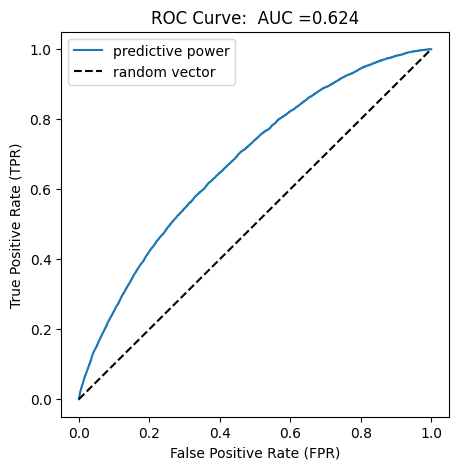

              precision    recall  f1-score   support

           0       0.86      0.63      0.72     40109
           1       0.32      0.62      0.42     11117

    accuracy                           0.63     51226
   macro avg       0.59      0.62      0.57     51226
weighted avg       0.74      0.63      0.66     51226



,predicted /n Major,predicted /n Minor
Actual Major,25170,14939
Actual Minor,4216,6901


In [67]:
# evaluate the random forest classifier
matrix, report = evaluate_classifier(rf_best, X_test, y_test)
matrix

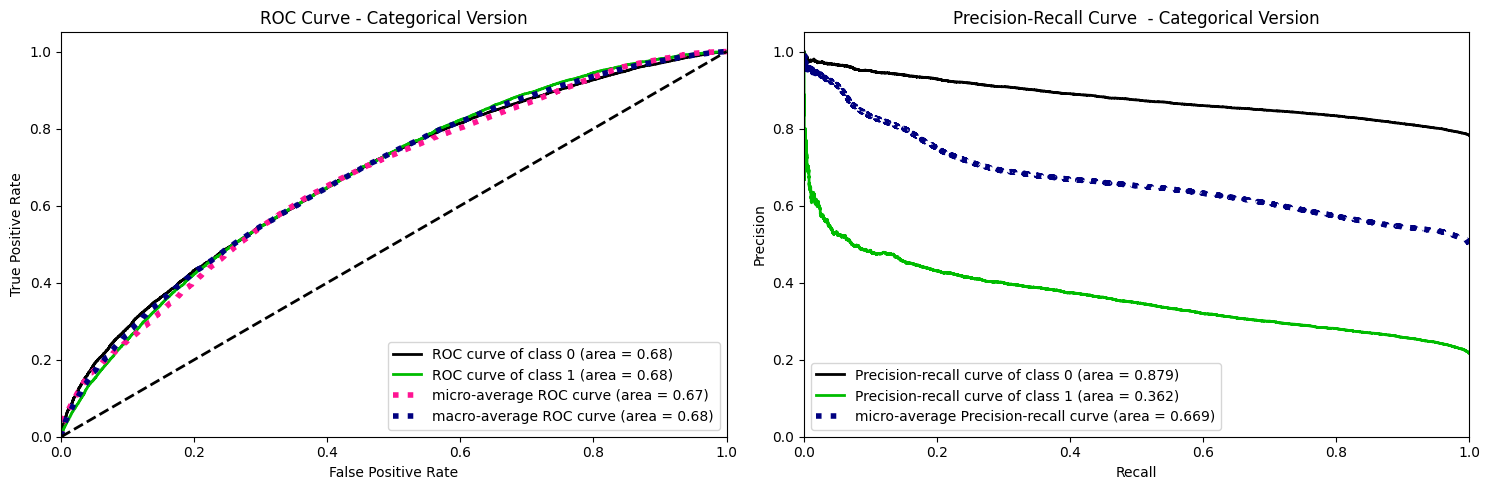

AUC score:  0.6241504751490661         AUPRC score:  0.3618004262149388


(0.6241504751490661, 0.3618004262149388)

In [68]:
ROC_PRC(rf_best, X_test, y_test)


## *Testing over samplingby SMOTE, performance on RF classifier*

In [31]:
## *Testing oversampling by SMOTE performance on RF classifier*
#define dataset as training and validation of undersampling categorical dataframe
X_train=Xe_train_os
y_train=ye_train_os
X_test=Xe_val
y_test=ye_val

#Define the F1 score scorer for the 'Major accidents ' class
scorer = make_scorer(f1_score, pos_label=1)

# ...

rf_us = RandomForestClassifier()#class_weight='balanced')
parameters_rf = {
    'n_estimators': [300, 200],
    'criterion': ["gini"], # "entropy"],
    'max_depth': [15],# 12],
    'max_features': ['sqrt']#,'log2']
}

rf_clf = GridSearchCV(rf_us, param_grid=parameters_rf, cv=5, scoring=scorer, n_jobs=-1)


t0 = time.time()
rf_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", rf_clf.best_params_)
print("Best score:", round(rf_clf.best_score_,2))


rf_best = rf_clf.best_estimator_


It takes 1378.292 seconds for tuning 
BEST PARAMS {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 300}


In [32]:
print("Best parameters:", rf_clf.best_params_)
print("Best score:", round(rf_clf.best_score_,2))

# predict the labels
y_pred = rf_best.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Minor', 'Major']))

Best parameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 300}
Best score: 0.71
              precision    recall  f1-score   support

       Minor       0.83      0.75      0.79     40109
       Major       0.33      0.44      0.38     11117

    accuracy                           0.69     51226
   macro avg       0.58      0.60      0.58     51226
weighted avg       0.72      0.69      0.70     51226



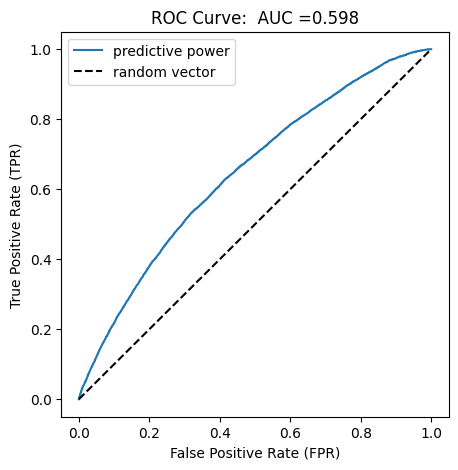

              precision    recall  f1-score   support

           0       0.83      0.75      0.79     40109
           1       0.33      0.44      0.38     11117

    accuracy                           0.69     51226
   macro avg       0.58      0.60      0.58     51226
weighted avg       0.72      0.69      0.70     51226



,predicted /n Major,predicted /n Minor
Actual Major,30237,9872
Actual Minor,6204,4913


In [52]:
# Here is a function to perform a quick evaluation of each model:
def evaluate_classifier(model, X_test, y_test,index = ['Actual Major', 'Actual Minor' ]):

    """
    Takes a model and its test data.
    Prints and returns model metrics.
    """

    # get predictions
    y_pred = model.predict(X_test)

    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)[:,1]

    # compute Area under the curve
    roc_auc = roc_auc_score(y_test, y_pred)

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # plot ROC curve
    title = 'ROC Curve:  AUC =' + str(roc_auc.round(3))
    _ = plt.figure(figsize=(5,5))
    _ = plt.plot(fpr, tpr)
    _ = plt.plot([0,1], [0,1], 'k--')
    _ = plt.xlabel('False Positive Rate (FPR)')
    _ = plt.ylabel('True Positive Rate (TPR)')
    _ = plt.title(title)
    _ = plt.legend(['predictive power','random vector'])
    # show plot when function is called, plot not returned
    plt.show()


    # construct confusion matrix
    #conf_matrx = pd.DataFrame(confusion_matrix(y_test, y_pred))
    #conf_matrx.columns = ['Predict: NO', 'Predict: YES']
    #conf_matrx.index = ['Actual: NO', 'Actual: YES']

    conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index = index,
                           columns = [f'predicted /n Major', f'predicted /n Minor'])

    conf_matrix

    # get classification report
    report = classification_report(y_test, y_pred)
    print(report)

    return conf_matrix, report

matrix, report = evaluate_classifier(rf_best, X_test, y_test)
matrix



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


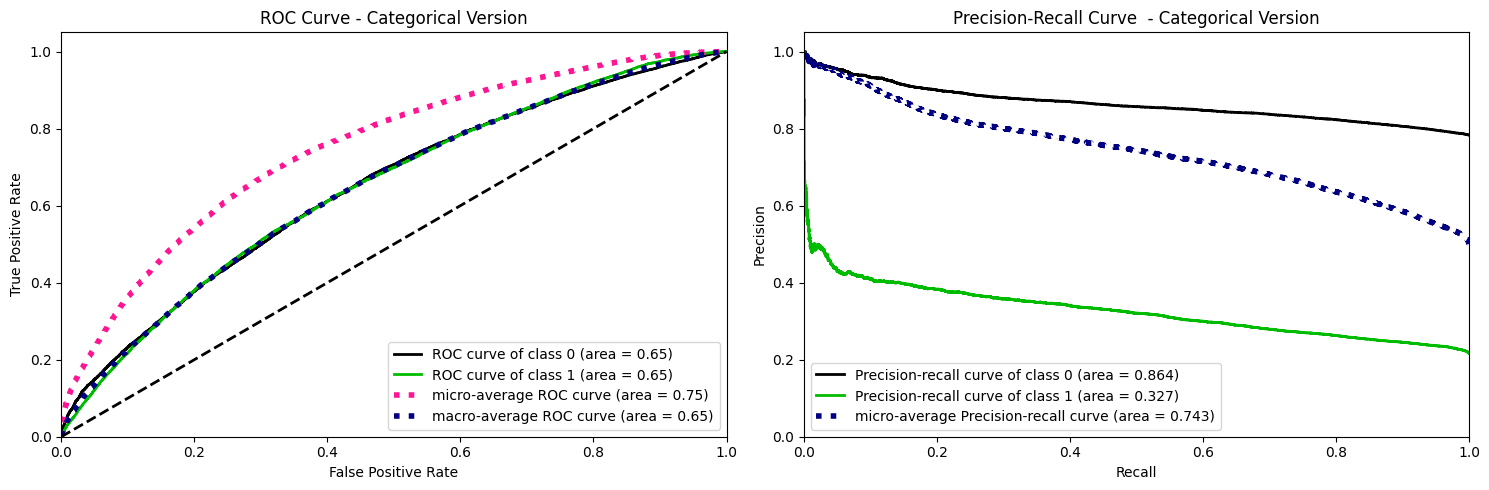

AUC score:  0.5979032381879464         AUPRC score:  0.3266494460773671


In [41]:
#plot roc curve and  print AUV score
y_probas = rf_best.predict_proba(X_test)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
skplt.metrics.plot_roc_curve(y_test, y_probas, ax=axes[0])
axes[0].set_title('ROC Curve - Categorical Version')
skplt.metrics.plot_precision_recall_curve(y_test, y_probas, ax=axes[1])
axes[1].set_title('Precision-Recall Curve  - Categorical Version')
plt.tight_layout()
plt.show()
auc_score = roc_auc_score(y_test, y_pred)
auprc_score = average_precision_score(y_test, y_probas[:, 1])
print('AUC score:  {}         AUPRC score:  {}'.format(auc_score,auprc_score))


## **Random Forest using balance weight and categorical features**::

In [ ]:
X = df_ml.drop(['accident_level'], axis=1)
y = df_ml['accident_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y, random_state=82)  # using stratify to have similar imbalance

# Define the F1 score scorer for the 'Major' class
scorer = make_scorer(f1_score, pos_label='Major')

# ...

rf_imbal = RandomForestClassifier(class_weight='balanced')
parameters_rf = {
    'n_estimators': [300, 200],
    'criterion': ["gini"], # "entropy"],
    'max_depth': [15],# 12],
    'max_features': ['sqrt']#,'log2']
}

rf_clf = GridSearchCV(rf_imbal, param_grid=parameters_rf, cv=5, scoring=scorer, n_jobs=-1)
t0 = time.time()
rf_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", rf_clf.best_params_)

rf_best = rf_clf.best_estimator_


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


It takes 730.095 seconds for tuning 
BEST PARAMS {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 300}


In [ ]:
print("Best parameters:", rf_clf.best_params_)
print("Best score:", round(rf_clf.best_score_,2))

# predict the labels
y_pred = rf_best.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Minor', 'Major']))

Best parameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 300}
Best score: nan
              precision    recall  f1-score   support

       Minor       0.84      0.72      0.78     48324
       Major       0.33      0.51      0.40     13394

    accuracy                           0.67     61718
   macro avg       0.59      0.61      0.59     61718
weighted avg       0.73      0.67      0.69     61718



In [ ]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['Major', 'Minor' ],
                           columns = ['predicted Major', 'predicted Minor'])
print("RF Confusion Matrix - Categorical version:")

conf_matrix


RF Confusion Matrix - Categorical version:


,predicted Major,predicted Minor
Major,34751,13573
Minor,6559,6835


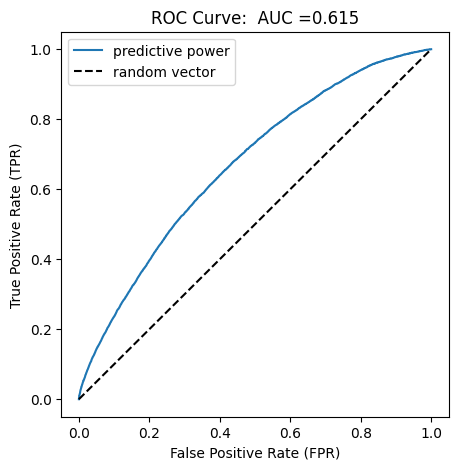

              precision    recall  f1-score   support

           0       0.84      0.72      0.78     48324
           1       0.33      0.51      0.40     13394

    accuracy                           0.67     61718
   macro avg       0.59      0.61      0.59     61718
weighted avg       0.73      0.67      0.69     61718



,Predict: NO,Predict: YES
Actual: NO,34751,13573
Actual: YES,6559,6835


In [ ]:
# evaluate the random forest classifier
matrix, report = evaluate_classifier(rf_best, X_test, y_test)
print(report)
matrix

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


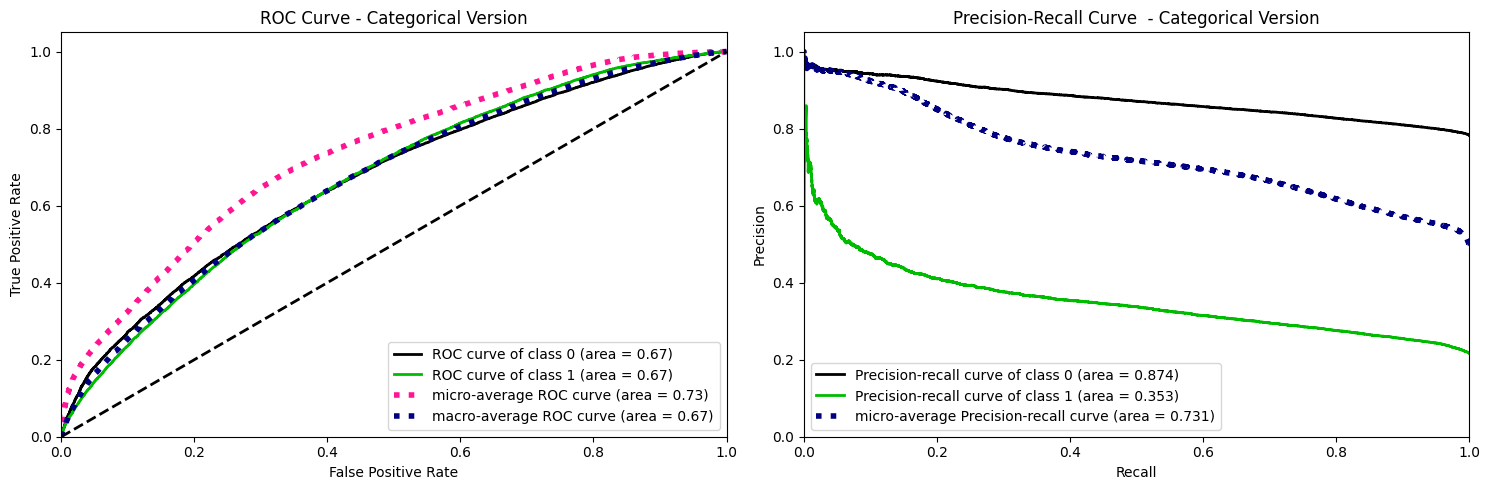

AUC score:  0.6147140966140687         AUPRC score:  0.3525464280837067


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
#plot roc curve and  print AUV score
y_probas = rf_best.predict_proba(X_test)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
skplt.metrics.plot_roc_curve(y_test, y_probas, ax=axes[0])
axes[0].set_title('ROC Curve - Categorical Version')
skplt.metrics.plot_precision_recall_curve(y_test, y_probas, ax=axes[1])
axes[1].set_title('Precision-Recall Curve  - Categorical Version')
plt.tight_layout()
plt.show()
auc_score = roc_auc_score(y_test, y_pred)
auprc_score = average_precision_score(y_test, y_probas[:, 1])
print('AUC score:  {}         AUPRC score:  {}'.format(auc_score,auprc_score))


In [ ]:
#!pip install scikit-plot
import scikitplot as skplt


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'latitude'),
  Text(1, 0, 'longitude'),
  Text(2, 0, 'number_of_vehicles'),
  Text(3, 0, 'police_force'),
  Text(4, 0, 'did_police_officer_attend_scene_of_accident'),
  Text(5, 0, 'hour'),
  Text(6, 0, 'month'),
  Text(7, 0, 'speed_limit'),
  Text(8, 0, 'urban_or_rural_area'),
  Text(9, 0, 'number_of_casualties'),
  Text(10, 0, 'junction_detail'),
  Text(11, 0, 'day_of_week'),
  Text(12, 0, 'road_type'),
  Text(13, 0, 'weather_conditions'),
  Text(14, 0, 'pedestrian_crossing_physical_facilities'),
  Text(15, 0, 'first_road_class'),
  Text(16, 0, 'light_conditions'),
  Text(17, 0, 'accident_year'),
  Text(18, 0, 'road_surface_conditions'),
  Text(19, 0, 'pedestrian_crossing_human_control')])

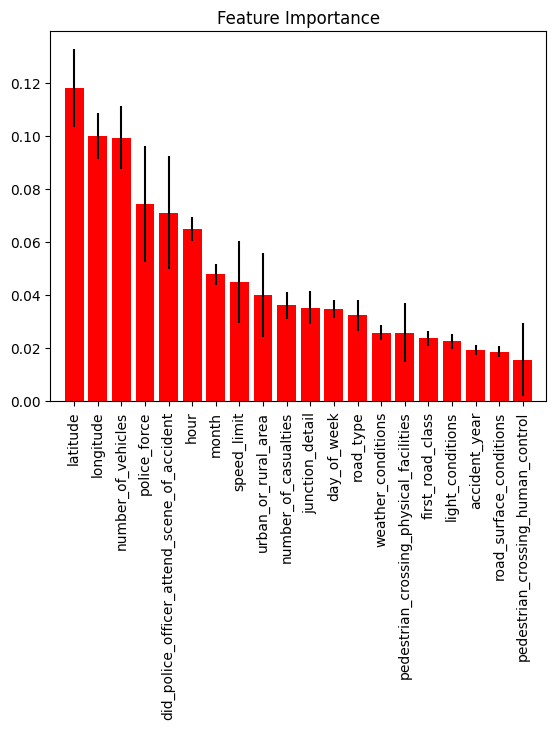

In [ ]:
skplt.estimators.plot_feature_importances(rf_best, feature_names= list(X_train.columns))
plt.xticks(rotation=90)

## **Random Forest using balance weight and OHE features**::

In [ ]:
X = df_ohe.drop(['accident_level'], axis=1)
y = df_ohe['accident_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y, random_state=82)  # using stratify to have similar imbalance

# Define the F1 score scorer for the 'Major' class
scorer = make_scorer(f1_score, pos_label=1)

# ...

rf_imbal = RandomForestClassifier(class_weight='balanced')
parameters_rf = {
    'n_estimators': [300, 200],
    'criterion': ["gini"], # "entropy"],
    'max_depth': [15],# 12],
    'max_features': ['sqrt']#,'log2']
}

rf_clf = GridSearchCV(rf_imbal, param_grid=parameters_rf, cv=5, scoring=scorer, n_jobs=-1)
t0 = time.time()
rf_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", rf_clf.best_params_)

rf_ohe_best = rf_clf.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


It takes 920.216 seconds for tuning 
BEST PARAMS {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 300}


In [ ]:
print("Best parameters:", rf_clf.best_params_)
print("Best score:", round(rf_clf.best_score_,2))

# predict the labels
y_pred = rf_ohe_best.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Minor', 'Major']))

Best parameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 300}
Best score: nan
              precision    recall  f1-score   support

       Minor       0.85      0.68      0.76     48324
       Major       0.33      0.56      0.41     13394

    accuracy                           0.65     61718
   macro avg       0.59      0.62      0.58     61718
weighted avg       0.74      0.65      0.68     61718



In [ ]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['Major', 'Minor' ],
                           columns = ['predicted Major', 'predicted Minor'])
print("RF Confusion Matrix - OHE version:")

conf_matrix

RF Confusion Matrix - OHE version:


,predicted Major,predicted Minor
Major,32889,15435
Minor,5865,7529


In [ ]:
class_weights = rf_imbal.class_weight_
print(class_weights)

AttributeError: ignored

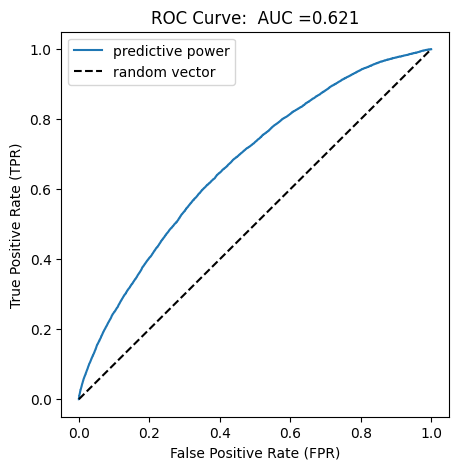

              precision    recall  f1-score   support

           0       0.85      0.68      0.76     48324
           1       0.33      0.56      0.41     13394

    accuracy                           0.65     61718
   macro avg       0.59      0.62      0.58     61718
weighted avg       0.74      0.65      0.68     61718



,Predict: NO,Predict: YES
Actual: NO,32889,15435
Actual: YES,5865,7529


In [ ]:
# evaluate the random forest classifier
matrix, report = evaluate_classifier(rf_ohe_best, X_test, y_test)
print(report)
matrix

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


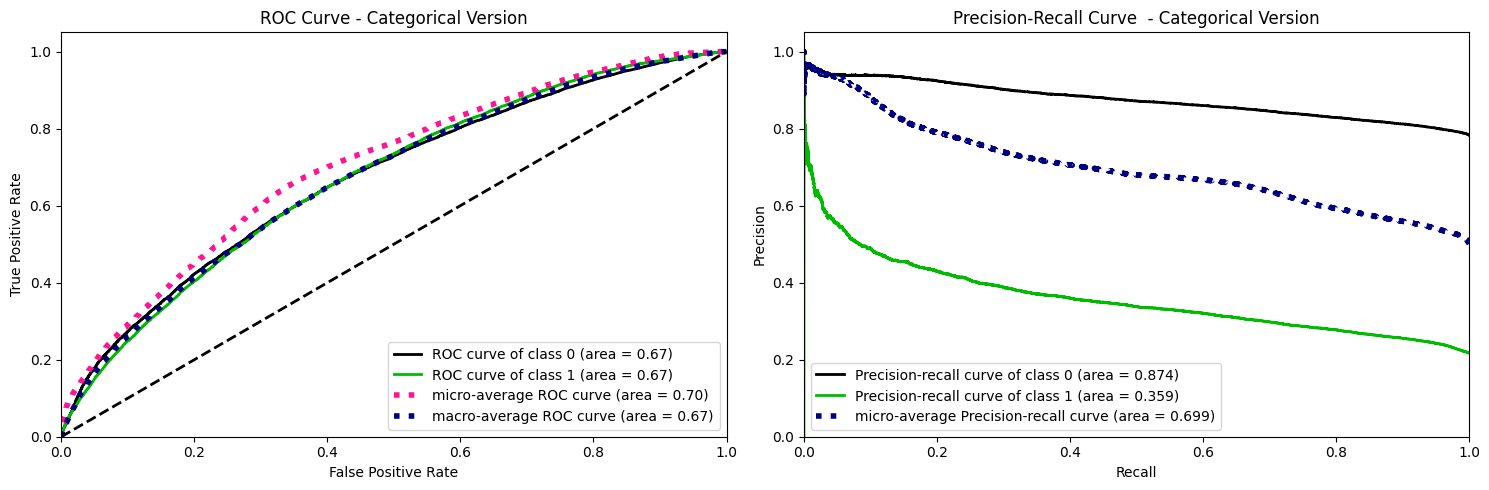

AUC score:  0.6213554299504179         AUPRC score:  0.3589375622968255


In [ ]:
#plot roc curve and  print AUV score
y_probas = rf_ohe_best.predict_proba(X_test)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
skplt.metrics.plot_roc_curve(y_test, y_probas, ax=axes[0])
axes[0].set_title('ROC Curve - Categorical Version')
skplt.metrics.plot_precision_recall_curve(y_test, y_probas, ax=axes[1])
axes[1].set_title('Precision-Recall Curve  - Categorical Version')
plt.tight_layout()
plt.show()
auc_score = roc_auc_score(y_test, y_pred)
auprc_score = average_precision_score(y_test, y_probas[:, 1])
print('AUC score:  {}         AUPRC score:  {}'.format(auc_score,auprc_score))


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'number_of_vehicles'),
  Text(1, 0, 'latitude'),
  Text(2, 0, 'did_police_officer_attend_scene_of_accident'),
  Text(3, 0, 'longitude'),
  Text(4, 0, 'speed_limit'),
  Text(5, 0, 'urban_or_rural_area'),
  Text(6, 0, 'number_of_casualties'),
  Text(7, 0, 'police_force_1'),
  Text(8, 0, 'road_type_6'),
  Text(9, 0, 'pedestrian_crossing_human_control_9.0'),
  Text(10, 0, 'pedestrian_crossing_physical_facilities_9.0'),
  Text(11, 0, 'trunk_road_flag_3.0'),
  Text(12, 0, 'junction_detail_0.0'),
  Text(13, 0, 'accident_year'),
  Text(14, 0, 'light_conditions_6.0'),
  Text(15, 0, 'junction_detail_1.0'),
  Text(16, 0, 'pedestrian_crossing_human_control_0.0'),
  Text(17, 0, 'light_conditions_1.0'),
  Text(18, 0, 'police_force_99'),
  Text(19, 0, 'police_force_52')])

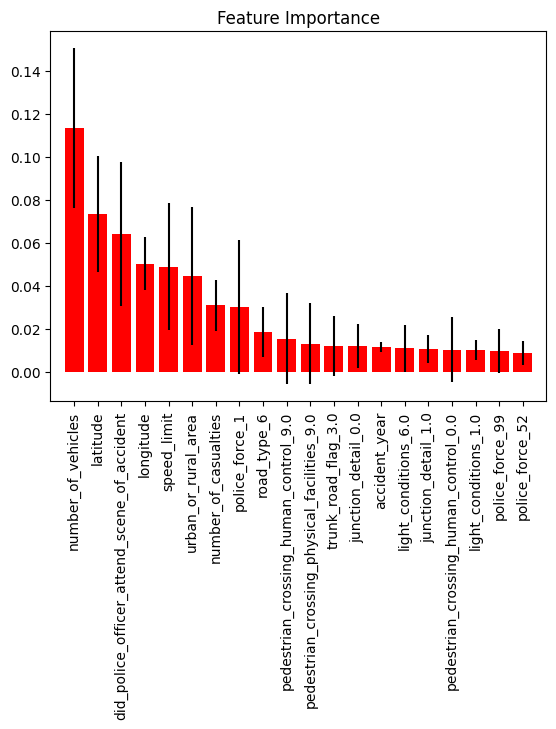

In [ ]:
skplt.estimators.plot_feature_importances(rf_ohe_best, feature_names= list(X_train.columns))
plt.xticks(rotation=90)

## Balanced Random Forest Classifier  BFR_CLF:  

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf_clf = BalancedRandomForestClassifier(n_estimators=300, criterion='gini', max_depth=15, max_features='sqrt')

t0 = time.time()
brf_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning" % (time_fit))
print("BEST PARAMS", brf_clf.get_params())

y_pred = brf_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Minor', 'Major']))


In [ ]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['Major', 'Minor' ],
                           columns = ['predicted Major', 'predicted Minor'])
print(classification_report(y_test, y_pred, target_names=['Minor', 'Major']))

print("RF Confusion Matrix - Categorical version:")

conf_matrix

              precision    recall  f1-score   support

       Minor       0.86      0.63      0.72     48324
       Major       0.32      0.62      0.42     13394

    accuracy                           0.63     61718
   macro avg       0.59      0.62      0.57     61718
weighted avg       0.74      0.63      0.66     61718

RF Confusion Matrix - Categorical version:


,predicted Major,predicted Minor
Major,30303,18021
Minor,5088,8306


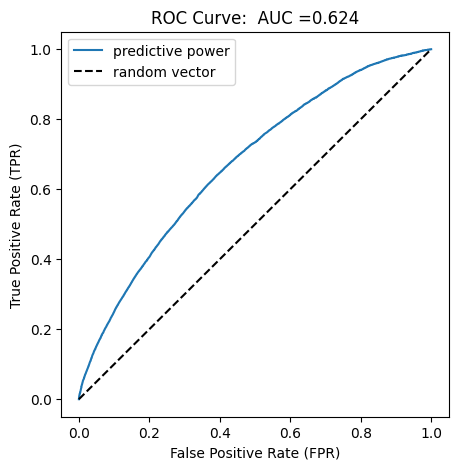

              precision    recall  f1-score   support

           0       0.86      0.63      0.72     48324
           1       0.32      0.62      0.42     13394

    accuracy                           0.63     61718
   macro avg       0.59      0.62      0.57     61718
weighted avg       0.74      0.63      0.66     61718



,Predict: NO,Predict: YES
Actual: NO,30303,18021
Actual: YES,5088,8306


In [ ]:
# evaluate the random forest classifier
matrix, report = evaluate_classifier(brf_clf, X_test, y_test)
print(report)
matrix

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


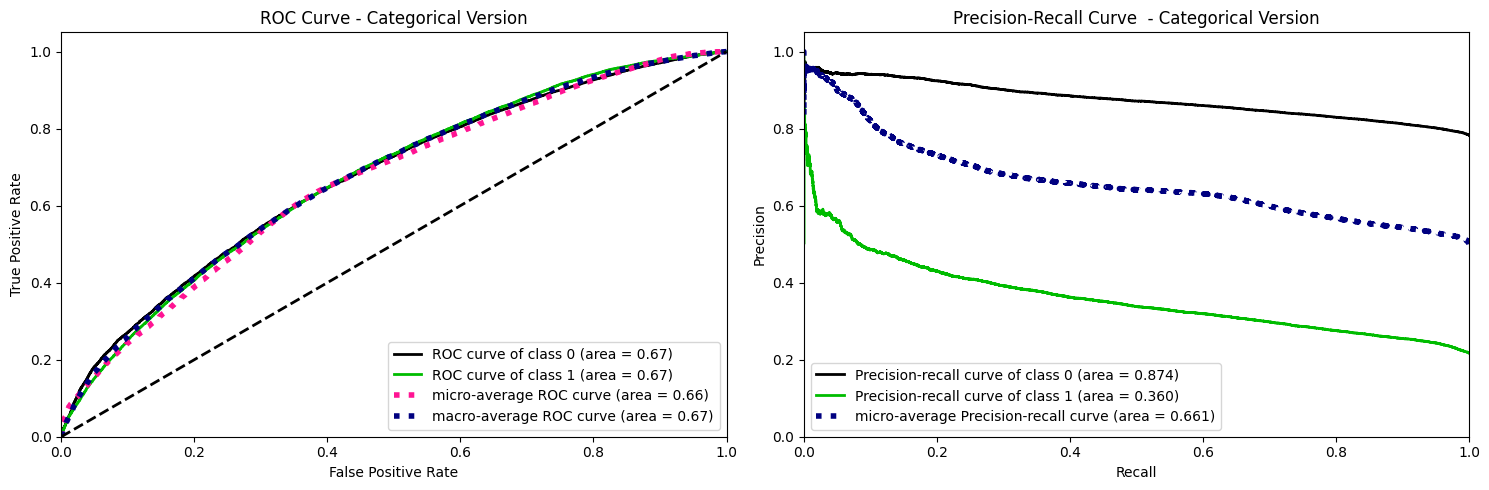

AUC score:  0.6236040638264508         AUPRC score:  0.359725235739216


In [ ]:
#plot roc curve and  print AUV score
y_probas = brf_clf.predict_proba(X_test)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
skplt.metrics.plot_roc_curve(y_test, y_probas, ax=axes[0])
axes[0].set_title('ROC Curve - Categorical Version')
skplt.metrics.plot_precision_recall_curve(y_test, y_probas, ax=axes[1])
axes[1].set_title('Precision-Recall Curve  - Categorical Version')
plt.tight_layout()
plt.show()
auc_score = roc_auc_score(y_test, y_pred)
auprc_score = average_precision_score(y_test, y_probas[:, 1])
print('AUC score:  {}         AUPRC score:  {}'.format(auc_score,auprc_score))


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'number_of_vehicles'),
  Text(1, 0, 'latitude'),
  Text(2, 0, 'did_police_officer_attend_scene_of_accident'),
  Text(3, 0, 'longitude'),
  Text(4, 0, 'speed_limit'),
  Text(5, 0, 'urban_or_rural_area'),
  Text(6, 0, 'police_force_1'),
  Text(7, 0, 'number_of_casualties'),
  Text(8, 0, 'road_type_6'),
  Text(9, 0, 'pedestrian_crossing_human_control_9.0'),
  Text(10, 0, 'accident_year'),
  Text(11, 0, 'junction_detail_0.0'),
  Text(12, 0, 'pedestrian_crossing_physical_facilities_9.0'),
  Text(13, 0, 'trunk_road_flag_3.0'),
  Text(14, 0, 'junction_detail_1.0'),
  Text(15, 0, 'light_conditions_1.0'),
  Text(16, 0, 'police_force_99'),
  Text(17, 0, 'light_conditions_6.0'),
  Text(18, 0, 'pedestrian_crossing_human_control_0.0'),
  Text(19, 0, 'police_force_52')])

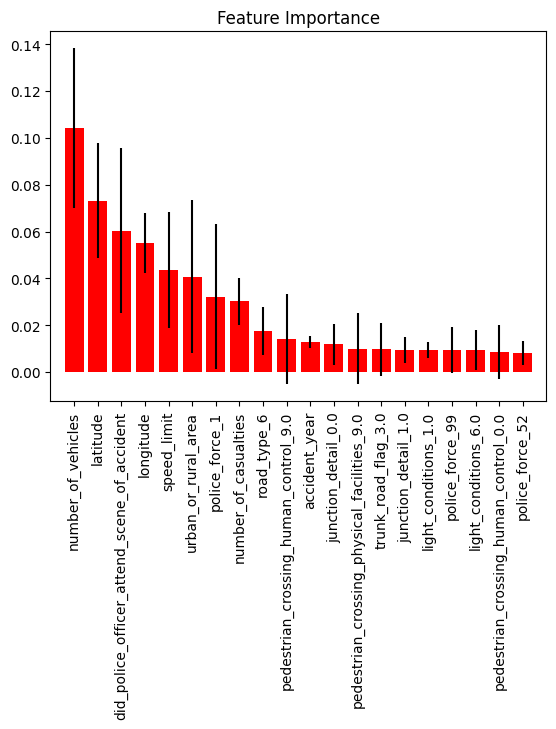

In [ ]:
skplt.estimators.plot_feature_importances(brf_clf, feature_names= list(X_train.columns))
plt.xticks(rotation=90)

Balancing with RF didn't solve it

UNDERSAMPLING:

# Older

In [ ]:
X = df_ml2.drop(['accident_level'], axis=1)
y = df_ml2['accident_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y, random_state=82)  # using stratify to have similar imbalance

rf_imbal = RandomForestClassifier(class_weight='balanced') # adding balanced to handle the unbalanced data
parameters_rf = {
                 'n_estimators': [100, 200],
                 'criterion': ["gini"],# "entropy"],
                 'max_depth': [10, 12],
                 'max_features': ['sqrt']  #auto raise a lot of warnings
                }

rf_clf = GridSearchCV(rf_imbal, param_grid = parameters_rf, cv = 5, scoring = 'accuracy')
t0 = time.time()
rf_clf.fit(X_train, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning " % (time_fit))
print("BEST PARAMS", rf_clf.best_params_)

rf_best = rf_clf.best_estimator_

It takes 534.183 seconds for tuning 
BEST PARAMS {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 100}


In [ ]:
print("Best parameters:", rf_clf.best_params_)
print("Best score:", round(rf_clf.best_score_,2))

# predict the labels
y_pred_best = rf_best.predict(X_test)
print(classification_report(y_test, y_pred_best, target_names=['Minor', 'Major']))

Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10}
Best score: 0.61
              precision    recall  f1-score   support

       Minor       0.85      0.62      0.72     29823
       Major       0.32      0.62      0.42      8476

    accuracy                           0.62     38299
   macro avg       0.58      0.62      0.57     38299
weighted avg       0.73      0.62      0.65     38299



In [ ]:
print("Best parameters:", rf_clf.best_params_)
print("Best score:", round(rf_clf.best_score_,2))

# predict the labels
y_pred_best = rf_best.predict(X_test)
print(classification_report(y_test, y_pred_best, target_names=['Minor', 'Major']))

Best parameters: {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 100}
Best score: 0.65
              precision    recall  f1-score   support

       Minor       0.86      0.66      0.74     29823
       Major       0.34      0.61      0.43      8476

    accuracy                           0.65     38299
   macro avg       0.60      0.63      0.59     38299
weighted avg       0.74      0.65      0.68     38299



In [ ]:
cv_score = cross_val_score(rf_best, X_train, y_train)
cv_score

In [ ]:
cv_score

array([0.63912008, 0.646072  , 0.64411371, 0.65082577, 0.64233958])

In [ ]:
print("Best parameters:", rf_clf.best_params_)
print("Best score:", round(rf_clf.best_score_,2))

# predict the labels
y_pred_best = rf_best.predict(X_test)
print(classification_report(y_test, y_pred_best, target_names=['Minor', 'Major']))

Best parameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 300}
Best score: nan
              precision    recall  f1-score   support

       Minor       0.84      0.73      0.78     29823
       Major       0.35      0.52      0.42      8476

    accuracy                           0.68     38299
   macro avg       0.60      0.62      0.60     38299
weighted avg       0.73      0.68      0.70     38299



In [ ]:
#df_rf.to_pickle("./drive/MyDrive/Accidents/Data/acc_rf.pkl")
import pickle
import datetime

# Generate a timestamp
timestamp = datetime.datetime.now().strftime("%m%d%H")

# Save the best model with a timestamp in the file name
file_name = f"rf_best_{timestamp}.pkl"
with open("./drive/MyDrive/Accidents/Data/"+file_name, 'wb') as file:
    pickle.dump(rf_best, file)


In [ ]:
# Get list of categorical columns
categorical_columns = X_train2.select_dtypes(include='category').columns

# Loop through each categorical column
for column in categorical_columns:
    # Get unique categories in training dataset
    train_categories = set(X_train2[column].unique())

    # Get unique categories in test dataset
    test_categories = set(X_test2[column].unique())

    # Find unseen categories in test dataset
    unseen_categories = test_categories - train_categories

    # Check if there are any unseen categories
    if unseen_categories:
        print(f"Unseen categories in column '{column}': {unseen_categories}")
    else:
        print(f"All categories in column '{column}' are seen in the training dataset")


All categories in column 'accident_year' are seen in the training dataset
All categories in column 'police_force' are seen in the training dataset
All categories in column 'day_of_week' are seen in the training dataset
All categories in column 'first_road_class' are seen in the training dataset
All categories in column 'road_type' are seen in the training dataset
All categories in column 'junction_detail' are seen in the training dataset
All categories in column 'pedestrian_crossing_human_control' are seen in the training dataset
All categories in column 'pedestrian_crossing_physical_facilities' are seen in the training dataset
All categories in column 'light_conditions' are seen in the training dataset
All categories in column 'weather_conditions' are seen in the training dataset
All categories in column 'road_surface_conditions' are seen in the training dataset
All categories in column 'special_conditions_at_site' are seen in the training dataset
All categories in column 'carriageway

In [ ]:
categorical_columns = X_train.select_dtypes(include=['category']).columns

min_values_categorical = X_train[categorical_columns].apply(lambda x: x.cat.as_ordered().min())

print(min_values_categorical)

accident_year                                  2020.0
police_force                                      1.0
day_of_week                                       1.0
first_road_class                                  1.0
road_type                                         1.0
junction_detail                                   0.0
pedestrian_crossing_human_control                 0.0
pedestrian_crossing_physical_facilities           0.0
light_conditions                                  1.0
weather_conditions                                1.0
road_surface_conditions                           1.0
special_conditions_at_site                        0.0
carriageway_hazards                               0.0
urban_or_rural_area                               1.0
did_police_officer_attend_scene_of_accident       1.0
trunk_road_flag                                   1.0
hour                                              0.0
weekend                                           0.0
month                       

In [ ]:
print(X_train2.nunique())
X_train2.info()

number_of_vehicles                             13
number_of_casualties                           16
speed_limit                                     6
accident_year                                   2
police_force                                   44
day_of_week                                     7
first_road_class                                6
road_type                                       6
junction_detail                                10
pedestrian_crossing_human_control               4
pedestrian_crossing_physical_facilities         7
light_conditions                                5
weather_conditions                              9
road_surface_conditions                         6
special_conditions_at_site                      9
carriageway_hazards                             7
urban_or_rural_area                             2
did_police_officer_attend_scene_of_accident     3
trunk_road_flag                                 3
hour                                           24


In [ ]:
from sklearn.naive_bayes import MultinomialNB


# Define the F1 score scorer for the 'Major' class
scorer = make_scorer(f1_score, pos_label='Major')

# Calculate class weights for imbalanced data
class_weights = dict(1 / y_train.value_counts(normalize=True))

X_train2 = X_train.drop(['longitude','latitude'], axis=1)
X_test2 = X_test.drop(['longitude','latitude'], axis=1)

# Convert binary columns in X_train to 'uint8'
X_train2['covid'] = X_train2['covid'].astype('uint8')
X_train2['weekend'] = X_train2['weekend'].astype('uint8')
X_train2['urban_or_rural_area'] = X_train2['urban_or_rural_area'].astype('uint8')

# Convert binary columns in X_test to 'uint8'
X_test2['covid'] = X_test2['covid'].astype('uint8')
X_test2['weekend'] = X_test2['weekend'].astype('uint8')
X_test2['urban_or_rural_area'] = X_test2['urban_or_rural_area'].astype('uint8')

# Convert binary column in y_train to 'uint8'
y_train = y_train.astype('uint8')
y_test = y_test.astype('uint8')

X_train2 = X_train2[['urban_or_rural_area','weekend','covid']]
X_test2 = X_test2[['urban_or_rural_area','weekend','covid']]

nb = MultinomialNB(class_prior=class_weights,alpha=1)

parameters_nb = {}

nb_clf = GridSearchCV(nb, param_grid=parameters_nb, cv=5, scoring=scorer, n_jobs=-1,error_score='raise')

t0 = time.time()
nb_clf.fit(X_train2, y_train)
time_fit = time.time() - t0
print("It takes %.3f seconds for tuning" % (time_fit))
print("BEST PARAMS", nb_clf.best_params_)

nb_best = nb_clf.best_estimator_

print("Best parameters:", rf_clf.best_params_)
print("Best score:", round(rf_clf.best_score_,2))

# predict the labels
y_pred_best = rf_best.predict(X_test2)
print(classification_report(y_test, y_pred_best, target_names=['Minor', 'Major']))

TypeError: ignored

In [ ]:
# Assuming your dataset is stored in a pandas DataFrame called 'df'

# Iterate through each column and check for dictionary values
for column in X_train2.columns:
    if any(isinstance(value, dict) for value in X_train2[column]):
        print(f"Column '{column}' contains dictionary values.")

if any(isinstance(value, dict) for value in y_train):
    print("The target variable 'y_train' contains dictionary values.")



In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
X_train2['covid'] = label_encoder.fit_transform(X_train2['covid'])
print(X_train2.min())
print(X_test2.min())
X_train2.info()

urban_or_rural_area    1
weekend                0
covid                  0
dtype: int64
urban_or_rural_area    1
weekend                0
covid                  0
dtype: uint8
<class 'pandas.core.frame.DataFrame'>
Int64Index: 153193 entries, 8662798 to 8613646
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   urban_or_rural_area  153193 non-null  uint8
 1   weekend              153193 non-null  uint8
 2   covid                153193 non-null  int64
dtypes: int64(1), uint8(2)
memory usage: 2.6 MB
